## Import modules and create Spark session

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
!pip install pyspark --quiet
from pyspark.sql import SparkSession
!pip install findspark --quiet
import findspark
findspark.init()

In [28]:
#import module
from pyspark.ml.recommendation import ALS

#create session
appName = "Recommender system in Spark"
spark = SparkSession \
    .builder \
    .appName(appName) \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

## Read file into dataFrame

In [29]:
ratings = spark.read.csv('/content/drive/MyDrive/movies.csv', inferSchema=True, header=True)
movies = spark.read.csv('/content/drive/MyDrive/ratings.csv', inferSchema=True, header=True)
movies.show(5)
ratings.show(5)
# joined_df = ratings.join(movies, ratings.movieId == movies.movieId, "outer")
joined_df = ratings.join(movies, on="movieId", how="outer")
joined_df.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
+------+-------+------+----------+
only showing top 5 rows

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

+-------+----------------+--------------------+------+------+----------+
|movieId|           title|              genres|userId|rating| timestamp|
+-------+------------

In [30]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
df = pd.read_csv("/content/drive/MyDrive/movie_dataset.csv")
df.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


In [31]:
features = ['genres', 'keywords', 'title', 'cast', 'director']
df['cast'].isnull().values.any()

True

In [32]:
def combine_features(row):
    return row['title']+' '+row['genres']+' '+row['director']+' '+row['keywords']+' '+row['cast']

for feature in features:
    df[feature] = df[feature].fillna('')

In [54]:
df['combined_features'] = df.apply(combine_features, axis = 1)
cv = CountVectorizer()
count_matrix = cv.fit_transform(df['combined_features'])
cosine_sim = cosine_similarity(count_matrix)

## Data preparation

In [34]:
def get_title_from_index(index):
    return df[df.index == index]["title"].values[0]
def get_index_from_title(title):
    return df[df.title == title]["index"].values[0]

In [35]:
movie_user_likes = "Pirates of the Caribbean: At World's End"
movie_index = get_index_from_title(movie_user_likes)
similar_movies = list(enumerate(cosine_sim[movie_index])) #accessing the row corresponding to given movie to find all the similarity scores for that movie and then enumerating over it
sorted_similar_movies = sorted(similar_movies,key=lambda x:x[1],reverse=True)[1:]

In [36]:
data = joined_df.select("userId", "movieId", "rating", "title")
splits = data.randomSplit([0.7, 0.3])
train = splits[0].withColumnRenamed("rating", "label")
test = splits[1].withColumnRenamed("rating", "trueLabel")
#calculate number of rows
train_rows = train.count()
test_rows = test.count()
print ("number of training data rows:", train_rows, ", number of testing data rows:", test_rows)

number of training data rows: 70036 , number of testing data rows: 30027


## Define model and train it

In [37]:
from pyspark.sql.functions import col

for column in train.columns:
    null_count = train.filter(col(column).isNull()).count()
    print(f"The column {column} has {null_count} null values.")

The column userId has 37 null values.
The column movieId has 0 null values.
The column label has 37 null values.
The column title has 0 null values.


In [38]:
train.show(10)
cleaned_train = train.dropna(subset=['userId', 'label'])
cleaned_train.printSchema()
cleaned_train.show(5)
from pyspark.sql.types import IntegerType, FloatType
cleaned_train = cleaned_train.withColumn("userId", cleaned_train["userId"].cast(IntegerType()))
cleaned_train = cleaned_train.withColumn("label", cleaned_train["label"].cast(FloatType()))
cleaned_train = cleaned_train.withColumn("movieId", cleaned_train["movieId"].cast(IntegerType()))
cleaned_train.printSchema()
cleaned_train.show(5)
missing_users = cleaned_train.filter(cleaned_train.userId.isNull()).count()
missing_movie = cleaned_train.filter(cleaned_train.movieId.isNull()).count()
missing_label = cleaned_train.filter(cleaned_train.label.isNull()).count()
missing_title = cleaned_train.filter(cleaned_train.title.isNull()).count()
print(missing_users)
print(missing_movie)
print(missing_label)
print(missing_title)
print(cleaned_train.columns)
print(spark.version)

+------+-------+-----+--------------------+
|userId|movieId|label|               title|
+------+-------+-----+--------------------+
|  NULL|   4712| NULL|Wild Child, The (...|
|  NULL|   5169| NULL|Scarlet Street (1...|
|  NULL|   5289| NULL|Body and Soul (1947)|
|  NULL|   5984| NULL|Story of O, The (...|
|  NULL|   6229| NULL|Two-Lane Blacktop...|
|  NULL|   6515| NULL|You Only Live Onc...|
|  NULL|   6683| NULL|         Fire (1996)|
|  NULL|   7335| NULL|Pickup on South S...|
|  NULL|   8236| NULL|While the City Sl...|
|  NULL|  25927| NULL|Stranger, The (1946)|
+------+-------+-----+--------------------+
only showing top 10 rows

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- title: string (nullable = true)

+------+-------+-----+--------------------+
|userId|movieId|label|               title|
+------+-------+-----+--------------------+
|     1|     31|  2.5|Dangerous Minds (...|
|     1|   1029|  3.0| 

In [39]:
als = ALS(maxIter=19, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="label")
sampled_data = cleaned_train.sample(withReplacement=False, fraction=0.9)
model = als.fit(sampled_data)
# model = als.fit(cleaned_train)
print("Training is done!")

Training is done!


In [40]:
test.show()
test.printSchema()
cleaned_test = test.dropna(subset=['userId', 'trueLabel'])

+------+-------+---------+--------------------+
|userId|movieId|trueLabel|               title|
+------+-------+---------+--------------------+
|  NULL|   4763|     NULL|Iron Ladies, The ...|
|  NULL|   6830|     NULL|  Sudden Fear (1952)|
|  NULL|   7243|     NULL|Intolerance: Love...|
|  NULL|   8494|     NULL|Cincinnati Kid, T...|
|  NULL|   8766|     NULL|  Black Angel (1946)|
|  NULL|   8767|     NULL|Big Clock, The (1...|
|  NULL|  34517|     NULL|      Berserk (1967)|
|  NULL|  41585|     NULL|Kiss of Death (1947)|
|  NULL|  48711|     NULL|Facing the Giants...|
|  NULL|  55946|     NULL|Lions For Lambs (...|
|  NULL| 110871|     NULL|  Rocket, The (2013)|
|  NULL| 114459|     NULL|White Bird in a B...|
|  NULL| 115139|     NULL|Challenge to Lass...|
|  NULL| 123663|     NULL|The Passionate Pl...|
|  NULL| 127144|     NULL|Drunk Stoned Bril...|
|  NULL| 127212|     NULL|The Stanford Pris...|
|  NULL| 128235|     NULL|Stormy Weather (1...|
|  NULL| 132547|     NULL|A Girl Like He

## Predict testing data

In [41]:
prediction = model.transform(cleaned_test)
print("testing is done!: ", prediction)
for column in prediction.columns:
    null_count = prediction.filter(col(column).isNull()).count()
    print(f"The column {column} has {null_count} null values.")
prediction.show(n=10, truncate=False)

testing is done!:  DataFrame[userId: int, movieId: int, trueLabel: double, title: string, prediction: float]
The column userId has 0 null values.
The column movieId has 0 null values.
The column trueLabel has 0 null values.
The column title has 0 null values.
The column prediction has 0 null values.
+------+-------+---------+-----------------------+-----------+
|userId|movieId|trueLabel|title                  |prediction |
+------+-------+---------+-----------------------+-----------+
|1     |1343   |2.0      |Cape Fear (1991)       |1.3726431  |
|1     |2105   |4.0      |Tron (1982)            |2.6260257  |
|1     |2455   |2.5      |Fly, The (1986)        |3.9241433  |
|2     |52     |3.0      |Mighty Aphrodite (1995)|3.7808242  |
|2     |150    |5.0      |Apollo 13 (1995)       |3.0611937  |
|2     |186    |3.0      |Nine Months (1995)     |2.2666526  |
|2     |208    |3.0      |Waterworld (1995)      |3.129305   |
|2     |223    |1.0      |Clerks (1994)          |3.4881535  |
|2    

In [42]:
# prediction.join(movies, "movieId").select("userId", "title", "prediction","trueLabel" ).show(n=10, truncate=False)

# movies.show(5)
new_pred = prediction.join(movies, on=["userId", "movieId"], how="outer").select("userId", "title", "prediction", "trueLabel")
new_pred = new_pred.dropna(subset=['userId', 'prediction', 'trueLabel'])
new_pred.show(n = 10, truncate = False)

+------+----------------------------------+-----------+---------+
|userId|title                             |prediction |trueLabel|
+------+----------------------------------+-----------+---------+
|1     |Cape Fear (1991)                  |1.3726431  |2.0      |
|1     |Tron (1982)                       |2.6260257  |4.0      |
|1     |Fly, The (1986)                   |3.9241433  |2.5      |
|2     |Apollo 13 (1995)                  |3.0611937  |5.0      |
|2     |Waterworld (1995)                 |3.129305   |3.0      |
|2     |Clerks (1994)                     |3.4881535  |1.0      |
|2     |Houseguest (1994)                 |-0.07563388|3.0      |
|2     |Clear and Present Danger (1994)   |2.917816   |4.0      |
|2     |Four Weddings and a Funeral (1994)|3.4804826  |3.0      |
|2     |Paper, The (1994)                 |4.673346   |3.0      |
+------+----------------------------------+-----------+---------+
only showing top 10 rows



In [43]:
i=0
print("Top 10 similar movies to "+movie_user_likes+" are:\n")
for element in sorted_similar_movies:
    print(get_title_from_index(element[0]))
    i=i+1
    if i>10:
        break

Top 10 similar movies to Pirates of the Caribbean: At World's End are:

Pirates of the Caribbean: The Curse of the Black Pearl
Pirates of the Caribbean: Dead Man's Chest
The Lord of the Rings: The Fellowship of the Ring
Seeking a Friend for the End of the World
The Lord of the Rings: The Return of the King
Pirates of the Caribbean: On Stranger Tides
Bedazzled
The Island
Kingdom of Heaven
The Lord of the Rings: The Two Towers
In the Name of the King: A Dungeon Siege Tale


## Evaluate the accuracy of our model

In [44]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol="trueLabel", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(prediction)
print ("Root Mean Square Error (RMSE):", rmse)

Root Mean Square Error (RMSE): nan


In [45]:
prediction.count()
a = prediction.count()
print("number of original data rows: ", a)
#drop rows with any missing data
cleanPred = prediction.dropna(how="any", subset=["prediction"])
b = cleanPred.count()
print("number of rows after dropping data with missing value: ", b)
print("number of missing data: ", a-b)

number of original data rows:  30005
number of rows after dropping data with missing value:  28668
number of missing data:  1337


In [46]:
rmse = evaluator.evaluate(cleanPred)
print ("Root Mean Square Error (RMSE):", rmse)

Root Mean Square Error (RMSE): 1.2676689465649722


In [47]:
cleanPred.show(5)

+------+-------+---------+--------------------+----------+
|userId|movieId|trueLabel|               title|prediction|
+------+-------+---------+--------------------+----------+
|   148|     32|      4.0|Twelve Monkeys (a...| 3.7776427|
|   148|     52|      4.0|Mighty Aphrodite ...| 4.5996203|
|   148|    232|      4.5|Eat Drink Man Wom...| 2.7192426|
|   148|    585|      2.5|Brady Bunch Movie...| 3.0897534|
|   148|    588|      4.0|      Aladdin (1992)| 3.9169507|
+------+-------+---------+--------------------+----------+
only showing top 5 rows



In [48]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, desc, abs
import os
import shutil

# Define a window spec
windowSpec = Window.partitionBy("userId").orderBy(desc("prediction"))

# Use the row_number function to assign a unique sequential number for each row, starting at 1, for each partition
numbered = cleanPred.withColumn("row_number", row_number().over(windowSpec))
condition2 = abs(numbered['trueLabel'] - numbered['prediction']) <= 1
numbered.show(5)
# Filter for the top 5 rows for each user
top5_per_user = numbered.filter((numbered.row_number <= 1) & condition2).drop("row_number")
# top5_per_user = top5_per_user.filter(abs(top5_per_user['trueLabel'] - top5_per_user['prediction']) <= 1)
top5_per_user.show(10)



+------+-------+---------+--------------------+----------+----------+
|userId|movieId|trueLabel|               title|prediction|row_number|
+------+-------+---------+--------------------+----------+----------+
|     1|   2455|      2.5|     Fly, The (1986)| 3.9241433|         1|
|     1|   2105|      4.0|         Tron (1982)| 2.6260257|         2|
|     1|   1343|      2.0|    Cape Fear (1991)| 1.3726431|         3|
|     2|    314|      4.0|Secret of Roan In...|  5.141057|         1|
|     2|    371|      3.0|   Paper, The (1994)|  4.673346|         2|
+------+-------+---------+--------------------+----------+----------+
only showing top 5 rows

+------+-------+---------+--------------------+----------+
|userId|movieId|trueLabel|               title|prediction|
+------+-------+---------+--------------------+----------+
|     3|   3949|      5.0|Requiem for a Dre...| 5.4142265|
|     5|   6377|      4.0| Finding Nemo (2003)|  4.535297|
|     6|   7153|      5.0|Lord of the Rings...|  4

In [49]:
# Show the results
path = "/content/drive/MyDrive/bda proj/top5_per_user.csv"

if os.path.exists(path):
    shutil.rmtree(path)  # for directory, you'll need to `import shutil` at the top

# Save the DataFrame to the location
top5_per_user.write.csv(path, header=True)
top5_per_user = top5_per_user.drop('trueLabel')
top5_per_user.show(5)

+------+-------+--------------------+----------+
|userId|movieId|               title|prediction|
+------+-------+--------------------+----------+
|     3|   3949|Requiem for a Dre...| 5.4142265|
|     5|   6377| Finding Nemo (2003)|  4.535297|
|     6|   7153|Lord of the Rings...|  4.698305|
|     7|    534|  Shadowlands (1993)| 4.8011813|
|     8|     47|Seven (a.k.a. Se7...|  5.386844|
+------+-------+--------------------+----------+
only showing top 5 rows



In [50]:
import matplotlib.pyplot as plt
import pandas as pd

pdf = cleanPred.toPandas()

<ipython-input-51-b264b0fc9c81>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 5], [0, 5], '--k', color='red') # Assuming ratings are from 0 to 5


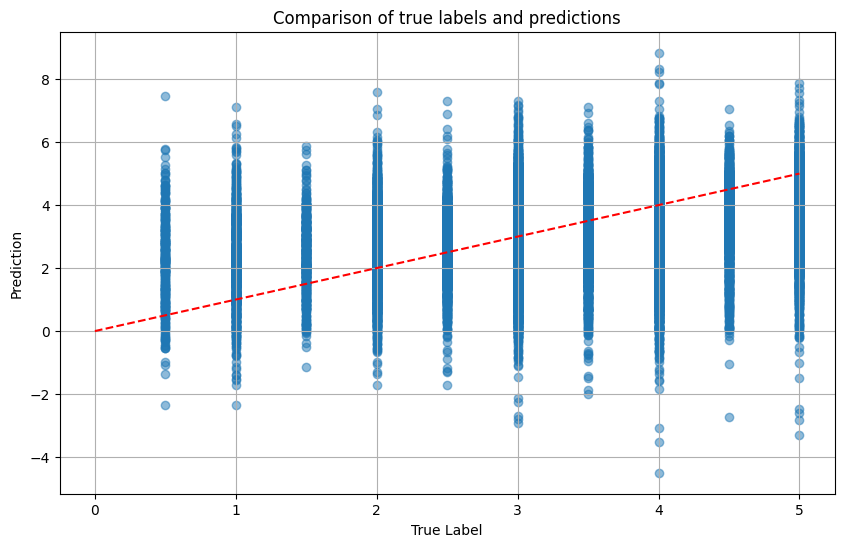

In [51]:
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(pdf['trueLabel'], pdf['prediction'], alpha=0.5)

# Line for perfect prediction
plt.plot([0, 5], [0, 5], '--k', color='red') # Assuming ratings are from 0 to 5

plt.xlabel('True Label')
plt.ylabel('Prediction')
plt.title('Comparison of true labels and predictions')
plt.grid(True)
plt.show()

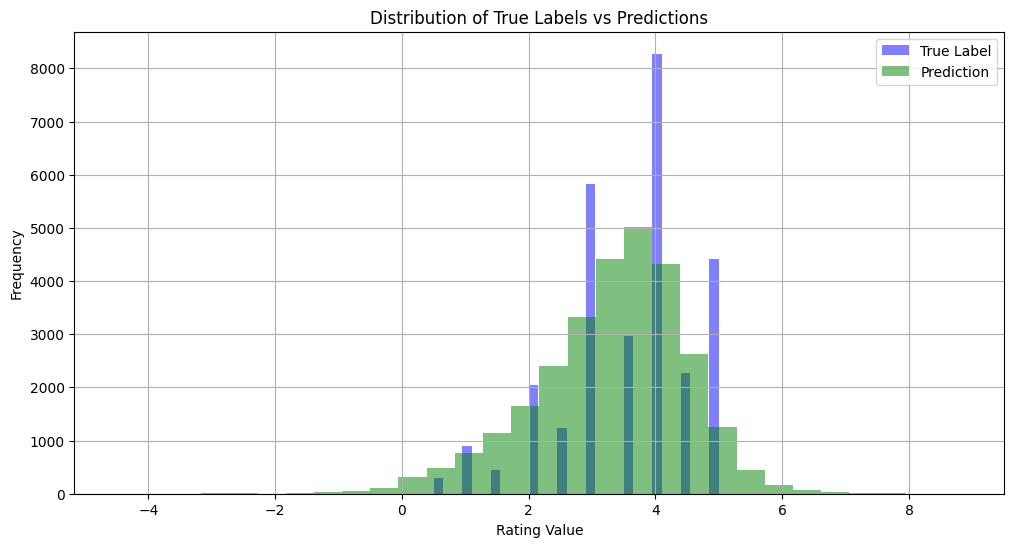

In [52]:
plt.figure(figsize=(12, 6))

# Histogram for trueLabel
plt.hist(pdf['trueLabel'], bins=30, alpha=0.5, label='True Label', color='blue')

# Histogram for prediction
plt.hist(pdf['prediction'], bins=30, alpha=0.5, label='Prediction', color='green')

plt.xlabel('Rating Value')
plt.ylabel('Frequency')
plt.title('Distribution of True Labels vs Predictions')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()